In [1]:
# imports
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from Levenshtein import distance as levenshtein_distance
import numpy as np

In [2]:
pl.Config.load_from_file("../polars_cfg.json")

In [3]:
# kaggle submission to analyze
submission_id = "claude3_5-langchain"

In [4]:
# load eval set
arc_all_tasks = pl.read_csv("../data/ARC_all_tasks_tests_stats.csv").filter(
    (pl.col("task_type") == "evaluation") & (pl.col("example_type") == "test")
)
arc_eval_tests = arc_all_tasks.select(
    "task_name",
    "example_number",
    "input_height",
    "input_width",
    "output_height",
    "output_width",
    "output_grid",
    "grid_size",
).rename({"output_grid": "true_output_grid", "example_number": "test_number"})

In [5]:
# load human / machine outputs
machine_submission = pl.read_csv(
    f"../data/kaggle_solutions/{submission_id}/submission.csv"
)

human_two_attempt_acc = pl.read_csv("../data/mean_task_acc_two_attempts.csv")
human_two_attempt_acc_training = human_two_attempt_acc.filter(
    pl.col("task_type") == "training"
).drop("task_type")

human_two_attempt_acc_eval = human_two_attempt_acc.filter(
    pl.col("task_type") == "evaluation"
).drop("task_type")

human_eval_summary = (
    pl.read_csv("../data/clean_summary_data_merged.csv")
    .filter(pl.col("task_type") == "evaluation")
    .drop("task_type")
)
# make human acc binary
human_two_attempt_acc_eval = human_two_attempt_acc_eval.with_columns(
    human_solved=(pl.col("mean_solved") > 0.0).cast(pl.Int32)
)
human_two_attempt_acc_training = human_two_attempt_acc_training.with_columns(
    human_solved=(pl.col("mean_solved") > 0.0).cast(pl.Int32)
)

# merge with h-arc
machine_submission = machine_submission.join(
    arc_eval_tests, on=["task_name", "test_number"]
)

# filter out tests that are not first
machine_filtered = machine_submission.filter(pl.col("test_number") == 1)
human_eval_summary = human_eval_summary.join(
    arc_eval_tests.filter(pl.col("test_number") == 1), on="task_name", how="left"
)

# add test_output_grid dimensions
human_eval_summary = human_eval_summary.with_columns(
    pl.col("test_output_grid").str.split("|").list.len().alias("test_output_height")
    - 2,
    pl.col("test_output_grid")
    .str.split("|")
    .list.get(1)
    .str.len_chars()
    .alias("test_output_width"),
)
machine_filtered = machine_filtered.with_columns(
    pl.col("test_output_grid").str.split("|").list.len().alias("test_output_height")
    - 2,
    pl.col("test_output_grid")
    .str.split("|")
    .list.get(1)
    .str.len_chars()
    .alias("test_output_width"),
)

In [6]:
def get_model_solved(df):
    df_ = df.with_columns(
        correct=pl.col("test_output_grid").eq(pl.col("true_output_grid")).cast(pl.Int32)
    )
    # model name
    name = df.unique("submission_id").select("submission_id").item()
    df_ = df_.with_columns(
        pl.when((pl.col("correct") == 1) & (pl.col("attempt_number") == 1))
        .then(1)
        .otherwise(0)
        .alias(f"{name}_solved_one_shot"),
        pl.when((pl.col("correct") == 1) & (pl.col("attempt_number") == 2))
        .then(1)
        .otherwise(0)
        .alias(f"{name}_solved_two_shot"),
    )
    df_ = df_.group_by(["task_name", "test_number"]).agg(
        pl.sum(f"{name}_solved_one_shot").alias(f"{name}_solved_one_shot"),
        pl.sum(f"{name}_solved_two_shot").alias(f"{name}_solved_two_shot"),
    )
    df_ = df_.with_columns(
        pl.when(
            (pl.col(f"{name}_solved_one_shot") == 1)
            | (pl.col(f"{name}_solved_two_shot") == 1)
        )
        .then(1)
        .otherwise(0)
        .alias(f"{name}_solved"),
    )
    df_ = df_.select(
        "task_name",
        "test_number",
        f"{name}_solved_one_shot",
        f"{name}_solved_two_shot",
        f"{name}_solved",
    )
    # print number of unique tasks
    print(f"Number of unique tasks attempted by {name}: {df_.n_unique('task_name')}")
    return df_

In [7]:
machine_solved = get_model_solved(machine_submission)

Number of unique tasks attempted by claude3_5-langchain: 150


In [8]:
# print 1 and 2 shot machine accuracy
print("1-shot accuracy")
print(50 * "-")

for model in [
    ("claude3_5-langchain", machine_solved),
]:
    mean_task_score = (
        model[1].group_by("task_name").agg(pl.mean(f"{model[0]}_solved_one_shot"))
    )
    num_solved = mean_task_score.filter(
        pl.col(f"{model[0]}_solved_one_shot") > 0.0
    ).height
    total = model[1].height
    print(
        f"{model[0]}: {round(mean_task_score.select(pl.mean(f'{model[0]}_solved_one_shot')).item()*100, 2)} ({num_solved}/{total} tests)"
    )

print("\n2-shot accuracy")
print(50 * "-")

for model in [
    ("claude3_5-langchain", machine_solved),
]:
    mean_task_score = model[1].group_by("task_name").agg(pl.mean(f"{model[0]}_solved"))
    num_solved = mean_task_score.filter(pl.col(f"{model[0]}_solved") > 0.0).height
    total = model[1].height
    print(
        f"{model[0]}: {round(mean_task_score.select(pl.mean(f'{model[0]}_solved')).item()*100, 2)} ({num_solved}/{total} tests)"
    )

1-shot accuracy
--------------------------------------------------
claude3_5-langchain: 19.33 (30/157 tests)

2-shot accuracy
--------------------------------------------------
claude3_5-langchain: 20.67 (32/157 tests)


In [9]:
# join to human data
human_machine = human_two_attempt_acc_eval.join(
    machine_solved.filter(pl.col("test_number") == 1), on="task_name", how="inner"
)

In [10]:
human_machine = human_machine.with_columns(
    pl.when((pl.col("human_solved") == 0) & (pl.col("claude3_5-langchain_solved") == 1))
    .then(pl.lit("machine_solved"))
    .when((pl.col("human_solved") == 1) & (pl.col("claude3_5-langchain_solved") == 0))
    .then(pl.lit("human_solved"))
    .when((pl.col("human_solved") == 0) & (pl.col("claude3_5-langchain_solved") == 0))
    .then(pl.lit("neither_solved"))
    .otherwise(pl.lit("both_solved"))
    .alias("solved_by"),
)

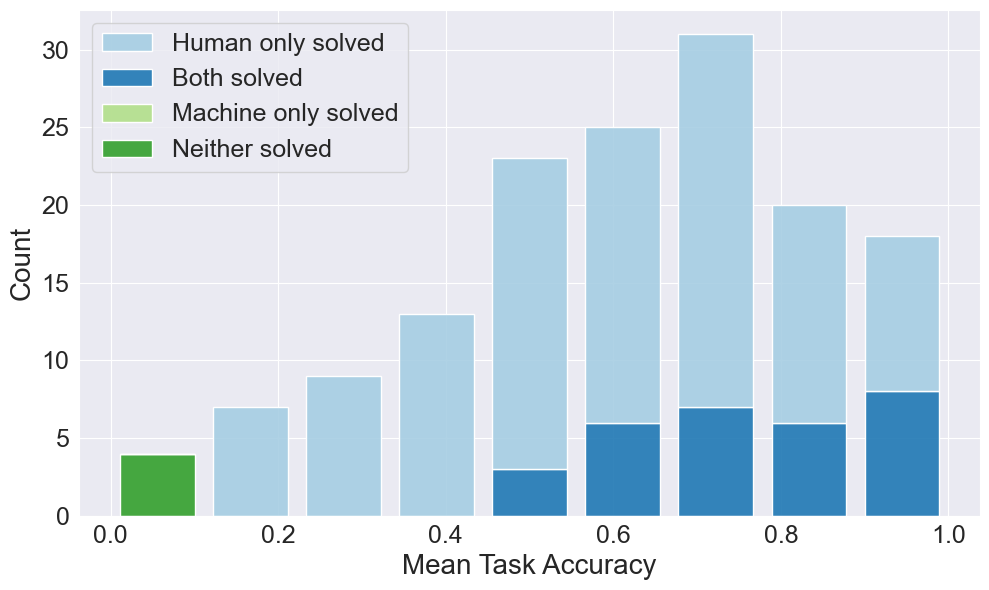

In [11]:
# plot human vs machine (greenblatt) accuracy distribution
sns.set_style("darkgrid")
colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c"]
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    human_machine,
    x="mean_solved",
    hue="solved_by",
    hue_order=["human_solved", "both_solved", "machine_solved", "neither_solved"],
    multiple="stack",
    palette=colors,
    shrink=0.8,
    alpha=0.9,
    ax=ax,
)
plt.xlabel("Mean Task Accuracy", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = ax.get_legend().legend_handles
labels = ["Human only solved", "Both solved", "Machine only solved", "Neither solved"]
plt.legend(handles=legend, labels=labels, fontsize=18)
total_tasks = human_machine.height
plt.tight_layout()
plt.savefig(
    f"../figures/human_{submission_id}_accuracy_distribution.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [12]:
total_tasks_machine_only = human_machine.filter(
    pl.col("solved_by") == "machine_solved"
).height
print(
    f"Number of tasks where {submission_id} solved but human did not: {total_tasks_machine_only}"
)

total_tasks_human_only = human_machine.filter(
    pl.col("solved_by") == "human_solved"
).height
print(
    f"Number of tasks where human solved but {submission_id} did not: {total_tasks_human_only}"
)

Number of tasks where claude3_5-langchain solved but human did not: 0
Number of tasks where human solved but claude3_5-langchain did not: 116


In [13]:
# sample 20 tasks that claude3_5-langchain solved
machine_solved = human_machine.filter(pl.col("solved_by") == "both_solved")
sampled_tasks = machine_solved.sample(n=20, seed=42)

print(f"Sample of 20 tasks solved by {submission_id}:")
sampled_tasks.head(10).sort("mean_solved", descending=True)

Sample of 20 tasks solved by claude3_5-langchain:


task_name,count,mean_solved,human_solved,test_number,claude3_5-langchain_solved_one_shot,claude3_5-langchain_solved_two_shot,claude3_5-langchain_solved,solved_by
str,i64,f64,i32,i64,i32,i32,i32,str
"""4cd1b7b2.json""",10,0.9,1,1,1,1,1,"""both_solved"""
"""1c0d0a4b.json""",7,0.857143,1,1,1,1,1,"""both_solved"""
"""59341089.json""",11,0.818182,1,1,1,1,1,"""both_solved"""
"""50a16a69.json""",8,0.75,1,1,1,1,1,"""both_solved"""
"""29700607.json""",12,0.75,1,1,1,1,1,"""both_solved"""
"""00576224.json""",6,0.666667,1,1,1,1,1,"""both_solved"""
"""009d5c81.json""",9,0.666667,1,1,0,1,1,"""both_solved"""
"""2c0b0aff.json""",11,0.636364,1,1,1,1,1,"""both_solved"""
"""0607ce86.json""",12,0.583333,1,1,1,1,1,"""both_solved"""


In [14]:
# compute edit distance for incorrect submission for models
machine_incorrect = (
    machine_filtered.filter(pl.col("test_output_grid") != pl.col("true_output_grid"))
    .with_columns(
        (
            pl.concat_list("test_output_grid", "true_output_grid").map_elements(
                lambda x: levenshtein_distance(x[0], x[1]), return_dtype=pl.Int32
            )
            / pl.col("grid_size")
        ).alias("levenshtein_distance")
    )
    .rename(
        {"output_height": "true_output_height", "output_width": "true_output_width"}
    )
)
human_incorrect = (
    human_eval_summary.filter(
        (pl.col("test_output_grid") != pl.col("true_output_grid"))
        & (pl.col("attempt_number") <= 2)
    )
    .with_columns(
        (
            pl.concat_list("test_output_grid", "true_output_grid").map_elements(
                lambda x: levenshtein_distance(x[0], x[1]), return_dtype=pl.Int32
            )
            / pl.col("grid_size")
        ).alias("levenshtein_distance")
    )
    .rename(
        {"output_height": "true_output_height", "output_width": "true_output_width"}
    )
)

In [15]:
# compute proportion of incorrect submissions with different output dimensions
def compute_incorrect_output_dims(df):
    df = df.with_columns(
        pl.when(
            (pl.col("true_output_height") != pl.col("test_output_height"))
            | (pl.col("true_output_width") != pl.col("test_output_width"))
        )
        .then(1)
        .otherwise(0)
        .alias("incorrect_output_dims")
    )
    return df


machine_incorrect = compute_incorrect_output_dims(machine_incorrect)
human_incorrect = compute_incorrect_output_dims(human_incorrect)

for name, df in [
    (f"{submission_id}", machine_incorrect),
    ("human", human_incorrect),
]:
    num_incorrect = df.filter(pl.col("incorrect_output_dims") == 1).height
    total = df.height

    print(
        f"Proportion of incorrect submissions with wrong output dimensions ({name}): {round(num_incorrect / total * 100, 2)}%"
    )

Proportion of incorrect submissions with wrong output dimensions (claude3_5-langchain): 10.25%
Proportion of incorrect submissions with wrong output dimensions (human): 26.17%


How much copying?


In [17]:
evaluation_set = pl.read_csv("../arc_data/ARC_evaluation_tasks.csv")
evaluation_set_train = evaluation_set.filter((pl.col("example_type") == "train"))
evaluation_set_test = evaluation_set.filter((pl.col("example_type") == "test"))
grid_agg_evaluation_train = evaluation_set_train.group_by("task_name").agg(
    pl.col("input_grid").alias("train_input_grids"),
    pl.col("output_grid").alias("train_output_grids"),
)
grid_agg_evaluation_test = evaluation_set_test.select(
    "task_name", "example_number", "input_grid", "output_grid"
).rename({"input_grid": "test_input_grid", "example_number": "test_number"})

In [18]:
def get_machine_copy_rate(df):
    df = (
        df.filter(pl.col("test_output_grid") != pl.col("true_output_grid"))
        .select("task_name", "test_output_grid", "test_number")
        .join(grid_agg_evaluation_test, on=["task_name", "test_number"], how="left")
        .join(grid_agg_evaluation_train, on="task_name", how="left")
    )
    df = df.with_columns(
        pl.col("test_output_grid")
        .is_in("train_input_grids")
        .alias("train_input_grid_copy"),
        pl.col("test_output_grid")
        .is_in("train_output_grids")
        .alias("train_output_grid_copy"),
        (pl.col("test_output_grid") == pl.col("test_input_grid")).alias(
            "test_input_grid_copy"
        ),
    )
    copy_rate_train_input = df.filter(pl.col("train_input_grid_copy")).height
    copy_rate_train_output = df.filter(pl.col("train_output_grid_copy")).height
    copy_rate_test_input = df.filter(pl.col("test_input_grid_copy")).height
    total = df.height
    return (
        copy_rate_train_input,
        copy_rate_train_output,
        copy_rate_test_input,
        total,
    )

In [19]:
machine_copying = get_machine_copy_rate(machine_submission)

In [20]:
print(
    f"{submission_id} Copy Rate (Train Input): {machine_copying[0] / machine_copying[3] * 100:.2f}%"
)
print(
    f"{submission_id} Copy Rate (Train Output): {machine_copying[1] / machine_copying[3] * 100:.2f}%"
)
print(
    f"{submission_id} Copy Rate (Test Input): {machine_copying[2] / machine_copying[3] * 100:.2f}%"
)
print(
    f"Total {submission_id} Copy Rate: {sum(machine_copying[0:3])/ machine_copying[3] * 100:.2f}%"
)

claude3_5-langchain Copy Rate (Train Input): 0.00%
claude3_5-langchain Copy Rate (Train Output): 1.18%
claude3_5-langchain Copy Rate (Test Input): 0.39%
Total claude3_5-langchain Copy Rate: 1.57%
